# Reshaping data for model
### In this file, we will take the data that has been gathered and harmonized and we will fit it, create scenarios, and save it as a structured array for the model. Since we would like to keep the flexibility with excel, we will also save it in an ODYM compatible format and create a file that can do the reverse: if teh excel file is eddited, so is the array. This will be a separate script

In [1]:
# Load a local copy of the current ODYM branch:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import xlrd
import pylab
from copy import deepcopy
import logging as log
import xlwt
import tqdm
import math
from scipy.stats import norm
from openpyxl import *
from scipy.optimize import curve_fit
from scipy.stats import gompertz
from sklearn.metrics import r2_score
from logistic import logistic as logistic
### Preamble

# add ODYM module directory to system path, relative
MainPath = os.path.join('/Users/fernaag/Box/BATMAN/Coding/Global_model', 'odym', 'modules')
sys.path.insert(0, MainPath)

# add ODYM module directory to system path, absolute
sys.path.insert(0, os.path.join(os.getcwd(), 'odym', 'modules'))

# Specify path to dynamic stock model and to datafile, relative
DataPath = os.path.join( 'docs', 'files')

# Specify path to dynamic stock model and to datafile, absolute
DataPath = os.path.join('/Users/fernaag/Box/BATMAN/Coding/Global_model', 'docs', 'Files')

import ODYM_Classes as msc # import the ODYM class file
import ODYM_Functions as msf # import the ODYM function file
import dynamic_stock_model as dsm # import the dynamic stock model library

# Initialize loggin routine
log_verbosity = eval("log.DEBUG")
log_filename = 'LogFileTest.md'
[Mylog, console_log, file_log] = msf.function_logger(log_filename, os.getcwd(),
                                                     log_verbosity, log_verbosity)
Mylog.info('### 1. - Initialize.')

#Read main script parameters
#Load project-specific config file
ProjectSpecs_ConFile = 'ODYM_Config_Vehicle_System.xlsx'
Model_Configfile     = xlrd.open_workbook(os.path.join(DataPath, ProjectSpecs_ConFile))
ScriptConfig         = {'Model Setting': Model_Configfile.sheet_by_name('Config').cell_value(3,3)} # Dictionary with config parameters
Model_Configsheet    = Model_Configfile.sheet_by_name('Setting_' + ScriptConfig['Model Setting'])

Name_Scenario        = Model_Configsheet.cell_value(3,3)
print(Name_Scenario)

#Read control and selection parameters into dictionary
ScriptConfig         = msf.ParseModelControl(Model_Configsheet,ScriptConfig)

Mylog.info('Read and parse config table, including the model index table, from model config sheet.')
IT_Aspects,IT_Description,IT_Dimension,IT_Classification,IT_Selector,IT_IndexLetter,\
PL_Names,PL_Description,PL_Version,PL_IndexStructure,PL_IndexMatch,PL_IndexLayer,\
PrL_Number,PrL_Name,PrL_Comment,PrL_Type,ScriptConfig = msf.ParseConfigFile(Model_Configsheet,ScriptConfig,Mylog)    

class_filename       = 'ODYM_Classifications_Master_Vehicle_System.xlsx'
Classfile            = xlrd.open_workbook(os.path.join(DataPath,class_filename))
Classsheet           = Classfile.sheet_by_name('MAIN_Table')
MasterClassification = msf.ParseClassificationFile_Main(Classsheet,Mylog)

Mylog.info('Define model classifications and select items for model classifications according to information provided by config file.')
ModelClassification  = {} # Dict of model classifications
for m in range(0,len(IT_Aspects)):
    ModelClassification[IT_Aspects[m]] = deepcopy(MasterClassification[IT_Classification[m]])
    EvalString = msf.EvalItemSelectString(IT_Selector[m],len(ModelClassification[IT_Aspects[m]].Items))
    if EvalString.find(':') > -1: # range of items is taken
        RangeStart = int(EvalString[0:EvalString.find(':')])
        RangeStop  = int(EvalString[EvalString.find(':')+1::])
        ModelClassification[IT_Aspects[m]].Items = ModelClassification[IT_Aspects[m]].Items[RangeStart:RangeStop]           
    elif EvalString.find('[') > -1: # selected items are taken
        ModelClassification[IT_Aspects[m]].Items = [ModelClassification[IT_Aspects[m]].Items[i] for i in eval(EvalString)]
    elif EvalString == 'all':
        None
    else:
        Mylog.error('Item select error for aspect ' + IT_Aspects[m] + ' were found in datafile.')
        break

# Define model index table and parameter dictionary
Mylog.info('### 2.2 - Define model index table and parameter dictionary')
Model_Time_Start = int(min(ModelClassification['Time'].Items))
Model_Time_End   = int(max(ModelClassification['Time'].Items))
Model_Duration   = Model_Time_End - Model_Time_Start + 1

Mylog.info('Define index table dataframe.')
IndexTable = pd.DataFrame({'Aspect'        : IT_Aspects,  # 'Time' and 'Element' must be present!
                           'Description'   : IT_Description,
                           'Dimension'     : IT_Dimension,
                           'Classification': [ModelClassification[Aspect] for Aspect in IT_Aspects],
                           'IndexLetter'   : IT_IndexLetter})  # Unique one letter (upper or lower case) indices to be used later for calculations.

# Default indexing of IndexTable, other indices are produced on the fly
IndexTable.set_index('Aspect', inplace=True)

# Add indexSize to IndexTable:
IndexTable['IndexSize'] = pd.Series([len(IndexTable.Classification[i].Items) for i in range(0, len(IndexTable.IndexLetter))],
                                    index=IndexTable.index)

# list of the classifications used for each indexletter
IndexTable_ClassificationNames = [IndexTable.Classification[i].Name for i in range(0, len(IndexTable.IndexLetter))]

# Define dimension sizes
Nt = len(IndexTable.Classification[IndexTable.index.get_loc('Time')].Items)
Nc = len(IndexTable.Classification[IndexTable.index.get_loc('Age-cohort')].Items)
Ng = len(IndexTable.Classification[IndexTable.index.get_loc('Good')].Items)
Nr = len(IndexTable.Classification[IndexTable.index.get_loc('Region')].Items)
Ne = len(IndexTable.Classification[IndexTable.index.get_loc('Element')].Items)
Nb = len(IndexTable.Classification[IndexTable.index.get_loc('Battery_Chemistry')].Items)
Nk = len(IndexTable.Classification[IndexTable.index.get_loc('Capacity')].Items)
Np = len(IndexTable.Classification[IndexTable.index.get_loc('Battery_Parts')].Items)
Ns = len(IndexTable.Classification[IndexTable.index.get_loc('Segment')].Items)
Nh = len(IndexTable.Classification[IndexTable.index.get_loc('Recycling_Process')].Items)
Nv = len(IndexTable.Classification[IndexTable.index.get_loc('Make')].Items)
NS = len(IndexTable.Classification[IndexTable.index.get_loc('Scenario')].Items)
Nz = len(IndexTable.Classification[IndexTable.index.get_loc('Stock_Scenarios')].Items)

INFO (<ipython-input-1-8341fa8fa5fc> <<module>>): ### 1. - Initialize.
INFO (<ipython-input-1-8341fa8fa5fc> <<module>>): Read and parse config table, including the model index table, from model config sheet.
INFO (ODYM_Functions.py <ParseConfigFile>): Read parameter list from model config sheet.
INFO (ODYM_Functions.py <ParseConfigFile>): Read process list from model config sheet.
INFO (ODYM_Functions.py <ParseConfigFile>): Read model run control from model config sheet.
INFO (ODYM_Functions.py <ParseConfigFile>): Read model output control from model config sheet.
INFO (ODYM_Functions.py <ParseClassificationFile_Main>): End of file or formatting error while reading the classification file in column 22. Check if all classifications are present. If yes, you are good to go!
INFO (<ipython-input-1-8341fa8fa5fc> <<module>>): Define model classifications and select items for model classifications according to information provided by config file.
INFO (<ipython-input-1-8341fa8fa5fc> <<module>

### We import the population data

In [2]:
pop = pd.read_csv('/Users/fernaag/Box/BATMAN/Data/Database/data/01_raw_data/population_global_UN/WPP2019_TotalPopulationBySex.csv')

In [3]:
for i in pop.Location.unique(): print(i)

Afghanistan
Africa
African Group
African Union
African Union: Central Africa
African Union: Eastern Africa
African Union: Northern Africa
African Union: Southern Africa
African Union: Western Africa
African, Caribbean and Pacific (ACP) Group of States
Albania
Algeria
American Samoa
Andean Community
Andorra
Angola
Anguilla
Antigua and Barbuda
Argentina
Armenia
Aruba
Asia
Asia-Pacific Economic Cooperation (APEC)
Asia-Pacific Group
Association of Southeast Asian Nations (ASEAN)
Australia
Australia/New Zealand
Austria
Azerbaijan
BRIC
BRICS
Bahamas
Bahrain
Bangladesh
Barbados
Belarus
Belgium
Belize
Belt-Road Initiative (BRI)
Belt-Road Initiative: Africa
Belt-Road Initiative: Asia
Belt-Road Initiative: Europe
Belt-Road Initiative: Latin America and the Caribbean
Belt-Road Initiative: Pacific
Benin
Bermuda
Bhutan
Black Sea Economic Cooperation (BSEC)
Bolivarian Alliance for the Americas (ALBA)
Bolivia (Plurinational State of)
Bonaire, Sint Eustatius and Saba
Bosnia and Herzegovina
Botswana
Br

In [4]:
pop = pop[(pop['Location']=='World') | (pop['Location']=='China') | ((pop['Location']=='Europe') & (pop['LocID']==908)) | (pop['Location']=='Japan') | (pop['Location']=='Republic of Korea') | (pop['Location']== 'Canada') | (pop['Location']=='United States of America') | (pop['Location']=='Mexico')]

In [5]:
for i in range(len(pop['Location'].values)):
    pop['Location'].values[i] = pop['Location'].values[i].upper()

In [6]:
pop.drop(['LocID', 'VarID', 'MidPeriod', 'PopMale', 'PopFemale', 'PopDensity'], axis=1, inplace=True)
pop.set_index(['Time', 'Variant'], inplace=True)

In [7]:
pop_eu = pop[pop['Location']=='EUROPE']
pop_pc = pop[pop['Location']=='CHINA']
pop_sk =  pop[pop['Location']=='JAPAN'] +pop[pop['Location']=='REPUBLIC OF KOREA'] 
pop_na = pop[pop['Location']=='CANADA'] +pop[pop['Location']=='UNITED STATES OF AMERICA']

In [8]:
pop_sk['Location'] = 'SOUTH KOREA AND JAPAN'
pop_na['Location'] = 'US AND CANADA'

In [9]:
pop_row = pop[pop['Location']=='WORLD']['PopTotal']  - pop_sk['PopTotal'] - pop_na['PopTotal'] - pop_pc['PopTotal'] - pop_eu['PopTotal'] 
pop_row = pd.DataFrame(pop_row)
#pop_row.rename_axis('Time', inplace=True)
pop_row['Location']='ROW'

In [10]:
pop_regions = pd.concat(([pop_eu, pop_pc, pop_sk, pop_na, pop_row]))

ipykernel_launcher:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



In [11]:
pop_regions.head()

,,Location,PopTotal
Time,Variant,,
1950,Medium,EUROPE,549328.859
1951,Medium,EUROPE,554324.506
1952,Medium,EUROPE,559694.362
1953,Medium,EUROPE,565281.964
1954,Medium,EUROPE,570969.740


In [12]:
pop_regions.reset_index(inplace=True)
pop_regions.set_index(['Time','Variant', 'Location'], inplace=True)

In [13]:
# We get rid of useless scenarios
pop_regions.drop(index=['Constant fertility', 'Instant replacement','Zero migration', 'Constant mortality', 'No change', 'Momentum','Median PI', 'Upper 80 PI', 'Lower 80 PI', 'Upper 95 PI', 'Lower 95 PI'], level=1, inplace=True) 

In [14]:
pop_regions.index.get_level_values('Variant').unique()

Index(['Medium', 'High', 'Low'], dtype='object', name='Variant')

In [15]:
pop_regions.reset_index(inplace=True)

In [16]:
gl = pop_regions.groupby(['Time', 'Variant']).sum()

In [17]:
gl.reset_index(inplace=True)

In [18]:
gl['Location'] = 'GLOBAL'

In [19]:
gl.sort_values(by=['Variant', 'Time'], inplace=True)

In [20]:
gl.set_index(['Time', 'Variant', 'Location'], inplace=True)
pop_regions.set_index(['Time', 'Variant', 'Location'], inplace=True)

In [21]:
pop_regions.index.get_level_values('Location').unique()

Index(['EUROPE', 'CHINA', 'SOUTH KOREA AND JAPAN', 'US AND CANADA', 'ROW'], dtype='object', name='Location')

In [22]:
population = pd.concat([pop_regions, gl], sort=True)

indfont: score(<Font '.New York' (NewYork.ttf) normal normal 400 normal>) = 10.05
DEBUG (font_manager.py <_findfont_cached>): findfont: score(<Font 'Brush Script MT' (Brush Script.ttf) italic normal 400 normal>) = 11.05
DEBUG (font_manager.py <_findfont_cached>): findfont: score(<Font 'Mishafi' (Mishafi.ttf) normal normal regular normal>) = 10.05
DEBUG (font_manager.py <_findfont_cached>): findfont: score(<Font 'Georgia' (Georgia Italic.ttf) italic normal 400 normal>) = 11.05
DEBUG (font_manager.py <_findfont_cached>): findfont: score(<Font '.SF NS Text Condensed' (SFNSTextCondensed-Heavy.otf) normal normal heavy condensed>) = 10.629999999999999
DEBUG (font_manager.py <_findfont_cached>): findfont: score(<Font 'STIXGeneral' (STIXGeneralBol.otf) normal normal bold normal>) = 10.335
DEBUG (font_manager.py <_findfont_cached>): findfont: score(<Font 'STIXVariants' (STIXVarBol.otf) normal normal bold normal>) = 10.335
DEBUG (font_manager.py <_findfont_cached>): findfont: score(<Font 'Noto S

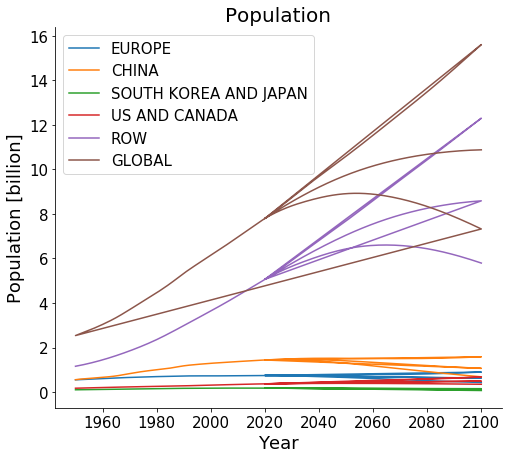

In [23]:
# For some reason the plot does not really show the data correctly. I plotted this in excel and it seems more correct that there are only 3 scenarios
fig, ax = plt.subplots(figsize=(8,7))
#ax.set_prop_cycle(custom_cycler)
for i,r in enumerate(population.index.get_level_values('Location').unique()):
    ax.plot(population[population.index.get_level_values('Location')==r].index.get_level_values('Time').values, 
            population[population.index.get_level_values('Location')==r].PopTotal.values/1000000)
    #ax.plot(vpc_regions[vpc_regions['Region']==r].index.values, 
        #       vpc_regions[vpc_regions['Region']==r].value.values, 'x')
    ax.set_ylabel('Population [billion]',fontsize =18)
    right_side = ax.spines["right"]
    right_side.set_visible(False)
    top = ax.spines["top"]
    top.set_visible(False)
    plt.grid()
    ax.legend(population.index.get_level_values('Location').unique(), loc='upper left',prop={'size':15})
    ax.set_title('Population', fontsize=20)
    ax.set_xlabel('Year',fontsize =18)
    ax.tick_params(axis='both', which='major', labelsize=15)

In [24]:
population.to_excel('/Users/fernaag/Box/BATMAN/Data/Database/data/02_harmonized_data/population_Global/population_UN_regions_scenarios.xlsx')
population.to_pickle('/Users/fernaag/Box/BATMAN/Data/Database/data/02_harmonized_data/population_Global/population_UN_regions_scenarios')

In [25]:
#population = pd.read_excel('/Users/fernaag/Box/BATMAN/Data/Database/data/01_raw_data/population_global_UN/population_global_1950_2050_UN.xlsx', sheet_name='Columns', skiprows=1)